### Question: does `model` returns `[0 prob, 1 prob]` before softmax?

In [1]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    AutoConfig,
    TextClassificationPipeline,
)
from engine.data import prepare_data_for_fine_tuning, read_data
from engine.xai import FeatureAblationText

c:\Users\1234o\Studies\Sem2\NLP\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
MODEL_ID = "roberta-base"
MODEL_PATH = "output/checkpoint-2025/model.safetensors"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

In [3]:
test = read_data("data/split_raw/test.tsv")
print(test)
test_dataset = prepare_data_for_fine_tuning(test, tokenizer)

                                                   text  label
0     Building a wall on the U.S.-Mexico border will...      0
1     Wisconsin is on pace to double the number of l...      1
2     Says John McCain has done nothing to help the ...      1
4     When asked by a reporter whether hes at the ce...      1
5     Over the past five years the federal governmen...      0
...                                                 ...    ...
1256  Says Chris Christies plan to kick-start our ec...      1
1257  Obama used $20 million in federal money to emm...      1
1260  I think its seven or eight of the California s...      1
1261  Sen. Bob Menendez voted to enact a new tax on ...      1
1266  Says the governor is going around the state ta...      1

[790 rows x 2 columns]


Map: 100%|██████████| 790/790 [00:00<00:00, 4858.54 examples/s]


In [4]:
import torch
def get_device():
    if torch.cuda.is_available():
        print("CUDA is available. Using GPU.")
        return "cuda"
    else:
        print("CUDA not available. Using CPU.")
        return "cpu"

In [5]:
config = AutoConfig.from_pretrained(MODEL_ID)
device = get_device()
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH, config=config
)
model.eval()
pipeline = TextClassificationPipeline(
    model=model, tokenizer=tokenizer, top_k=2, device=device
)

CUDA not available. Using CPU.


In [6]:
%%capture
if(device == "cuda"):
    model.cuda()
else:
    model.cpu()

In [7]:
obs = test["text"].tolist()[0]
if(device == "cuda"):
    obs_pt = pipeline.tokenizer(obs, return_tensors="pt")['input_ids'].cuda()
else:
    obs_pt = pipeline.tokenizer(obs, return_tensors="pt")['input_ids'].cpu()

print(obs)
print(obs_pt)


Building a wall on the U.S.-Mexico border will take literally years.
tensor([[    0, 37500,    10,  2204,    15,     5,   121,     4,   104,  3358,
         15780,  1424,    40,   185,  5909,   107,     4,     2]])


In [8]:
def forward(obs):
    return model(obs).logits

In [9]:

attr = FeatureAblationText(forward)
print(attr)
exp = attr.get_attributions([obs_pt])
exp

tensor([[[ 0.0000e+00,  1.2517e-06,  3.8594e-06,  2.4736e-06,  6.5118e-06,
           1.7881e-06,  4.5747e-06,  3.7402e-06,  8.7619e-06,  4.3064e-06,
           1.2890e-05,  4.6194e-06,  4.6492e-06,  1.9222e-06,  4.7684e-07,
           5.4240e-06,  4.8280e-06,  6.5118e-06],
         [ 0.0000e+00,  5.9605e-08,  1.9260e-06,  1.1623e-06,  2.6114e-06,
           9.5740e-07,  2.2333e-06,  1.8384e-06,  4.2710e-06,  2.2557e-06,
           5.8804e-06,  1.8310e-06,  1.8794e-06,  7.7300e-07, -1.0617e-07,
           2.6375e-06,  2.9430e-06,  3.6247e-06]]])

In [10]:
tokens = pipeline.tokenizer.convert_ids_to_tokens(obs_pt[0])
print(tokens)

['<s>', 'Building', 'Ġa', 'Ġwall', 'Ġon', 'Ġthe', 'ĠU', '.', 'S', '.-', 'Mexico', 'Ġborder', 'Ġwill', 'Ġtake', 'Ġliterally', 'Ġyears', '.', '</s>']


In [ ]:
import spacy

NER = spacy.load("en_core_web_sm")

doc = NER(obs)

print("Entities in the text:")
for ent in doc.ents:
    print(f"{ent.text} ({ent.label_}) - {spacy.explain(ent.label_)}")

Entities in the text:
U.S.-Mexico (ORG) - Companies, agencies, institutions, etc.
literally years (DATE) - Absolute or relative dates or periods


In [12]:
print("\nTokens and Their NER Information: \n")

for token in doc:
    if token.ent_type_:
        print(f"Token: {token.text}, Entity Type: {token.ent_type_} ({spacy.explain(token.ent_type_)})")
    else:
        print(f"Token: {token.text}, Not part of any entity.")


Tokens and Their NER Information: 

Token: Building, Not part of any entity.
Token: a, Not part of any entity.
Token: wall, Not part of any entity.
Token: on, Not part of any entity.
Token: the, Not part of any entity.
Token: U.S.-Mexico, Entity Type: ORG (Companies, agencies, institutions, etc.)
Token: border, Not part of any entity.
Token: will, Not part of any entity.
Token: take, Not part of any entity.
Token: literally, Entity Type: DATE (Absolute or relative dates or periods)
Token: years, Entity Type: DATE (Absolute or relative dates or periods)
Token: ., Not part of any entity.


In [ ]:
print(len(tokens))

tokens_clear = [s.replace("Ġ", "") for s in tokens]
tokens_clear = tokens_clear[1:len(tokens_clear)-1]
print(tokens_clear)

print(exp)
print(len(exp))

18
['Building', 'a', 'wall', 'on', 'the', 'U', '.', 'S', '.-', 'Mexico', 'border', 'will', 'take', 'literally', 'years', '.']
tensor([[[ 0.0000e+00,  1.2517e-06,  3.8594e-06,  2.4736e-06,  6.5118e-06,
           1.7881e-06,  4.5747e-06,  3.7402e-06,  8.7619e-06,  4.3064e-06,
           1.2890e-05,  4.6194e-06,  4.6492e-06,  1.9222e-06,  4.7684e-07,
           5.4240e-06,  4.8280e-06,  6.5118e-06],
         [ 0.0000e+00,  5.9605e-08,  1.9260e-06,  1.1623e-06,  2.6114e-06,
           9.5740e-07,  2.2333e-06,  1.8384e-06,  4.2710e-06,  2.2557e-06,
           5.8804e-06,  1.8310e-06,  1.8794e-06,  7.7300e-07, -1.0617e-07,
           2.6375e-06,  2.9430e-06,  3.6247e-06]]])
1


In [ ]:
from tokens_aggregate import *

In [28]:
aggregate_list = generate_aggregate_list(doc,exp,tokens_clear,tokens)

In [29]:
i = 0
for aggregate in aggregate_list:
    print(f"Agregate nr: {i}")
    print(f"Is spacy NER: {aggregate.is_spacy_NER}")
    print(f"spacy token: {aggregate.get_spacy_token()}")
    clean,dirty = aggregate.get_model_tokens()
    print(f"Our model clean: {clean}")
    print(f"Our model dirty: {dirty}")
    print(f"model exp {aggregate.get_model_exp()}")
    print("\n")
    i=i+1


Agregate nr: 0
Is spacy NER: False
spacy token: This
Our model clean: ['This']
Our model dirty: ['This']
model exp [tensor(-8.6427e-07)]


Agregate nr: 1
Is spacy NER: False
spacy token: would
Our model clean: ['would']
Our model dirty: ['Ġwould']
model exp [tensor(-1.0673e-06)]


Agregate nr: 2
Is spacy NER: False
spacy token: be
Our model clean: ['be']
Our model dirty: ['Ġbe']
model exp [tensor(1.6764e-08)]


Agregate nr: 3
Is spacy NER: False
spacy token: the
Our model clean: ['the']
Our model dirty: ['Ġthe']
model exp [tensor(-3.7365e-06)]


Agregate nr: 4
Is spacy NER: False
spacy token: largest
Our model clean: ['largest']
Our model dirty: ['Ġlargest']
model exp [tensor(-1.6391e-07)]


Agregate nr: 5
Is spacy NER: False
spacy token: casino
Our model clean: ['casino']
Our model dirty: ['Ġcasino']
model exp [tensor(3.7067e-07)]


Agregate nr: 6
Is spacy NER: False
spacy token: in
Our model clean: ['in']
Our model dirty: ['Ġin']
model exp [tensor(2.2408e-06)]


Agregate nr: 7
Is spa

In [18]:
NER = spacy.load("en_core_web_sm")
all_aggregate = []
i =0
for obs in test["text"].tolist():
    print(i)
    i=i+1
    if(device == "cuda"):
        obs_pt = pipeline.tokenizer(obs, return_tensors="pt")['input_ids'].cuda()
    else:
        obs_pt = pipeline.tokenizer(obs, return_tensors="pt")['input_ids'].cpu()
    attr = FeatureAblationText(forward)

    exp = attr.get_attributions([obs_pt])
    tokens = pipeline.tokenizer.convert_ids_to_tokens(obs_pt[0])


    doc = NER(obs)
    tokens_clear = [s.replace("Ġ", "") for s in tokens]
    tokens_clear = tokens_clear[1:len(tokens_clear)-1]
    spacy_token_to_our_tokens = generate_aggregate_list(doc,exp,tokens_clear,tokens)
    all_aggregate = all_aggregate+spacy_token_to_our_tokens


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111


KeyboardInterrupt: 

C:\Users\1234o\AppData\Local\Temp\ipykernel_17884\2923972711.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(arrays, labels=labels)


{'whiskers': [<matplotlib.lines.Line2D at 0x21f200f18e0>,
 'caps': [<matplotlib.lines.Line2D at 0x21f200f1d60>,
 'boxes': [<matplotlib.lines.Line2D at 0x21f200edb50>,
 'medians': [<matplotlib.lines.Line2D at 0x21f200f22d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x21f200f25d0>,
 'means': []}

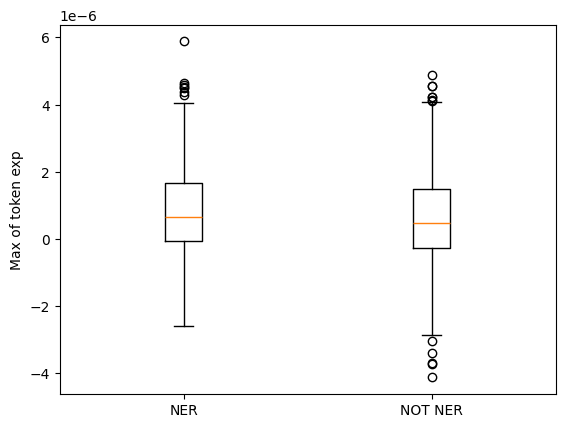

In [27]:
import numpy as np
import matplotlib.pyplot as plt
i = 0
NER_values = []
non_NER_values = []
for aggregate in all_aggregate:
    value = np.max(aggregate.get_model_exp())
    if(aggregate.is_spacy_NER):
        NER_values.append(value)
    else:
        non_NER_values.append(value)

data_to_show = {"NER":NER_values,"NOT NER":non_NER_values}
arrays = list(data_to_show.values())
labels = list(data_to_show.keys())
plt.ylabel("Max of token exp")

plt.boxplot(arrays, labels=labels)